# Example: Min Cost Max Flow as a Dual Linear Programming Problem
In this example, we will revisit the minimum cost maximum flow problem and see how it can be formulated and **solved as a dual linear programming (LP) problem**.

> **Learning objectives:**
>
> In this example, students will learn to:
>
> * **Formulate the dual of flow problems.** We translate a minimum cost maximum flow problem on a graph into its dual linear programming formulation, focusing on dual variables (shadow prices) rather than flows.
> * **Solve dual linear programming problems.** We use the GLPK solver through JuMP to solve the dual problem and extract optimal dual variables (node prices/shadow prices).
> * **Interpret dual solutions economically.** We analyze the dual variables as shadow prices and understand their economic meaning in terms of marginal costs and resource valuations in the network.

This is an extremely useful problem formulation that can be used to solve a variety of practical problems, such as logistics, supply chain management, and operations scheduling optimization. Let's get started!
___

## Setup, Data, and Prerequisites
First, we set up the computational environment by including the `Include.jl` file and loading any needed resources.

> __Include:__ The [include command](https://docs.julialang.org/en/v1/base/base/#include) evaluates the contents of the input source file `Include.jl` in the notebook's global scope. The `Include.jl` file sets paths, loads required external packages, and more. For additional information on functions and types used in this material, see the [Julia programming language documentation](https://docs.julialang.org/en/v1/).

Let's set up our environment:

In [3]:
include(joinpath(@__DIR__, "Include.jl"));

In addition to standard Julia libraries, we'll also use the [`VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl). Check out [the documentation](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/) for more information on the functions, types, and data used in this material. 

### Constants
Let's define some constants that will be used throughout the notebook. See the comment for a description of each constant, what it represents, its value, units, and more.

In [6]:
# We are going to plot the path through a graph, so let's provide the coordinates for each node (the layout)
# This layout looks like our schematic but you can rearrange this if you want!
node_coordinates = [

    # source node (you)
    10.0 10.0 ; # 1 source node s (x,y) coordinates

    # people nodes (workers)
    11.0 11.0 ; # 2 people node (x,y) coordinates
    11.0 10.0 ; # 3 people node (x,y) coordinates
    11.0 9.0 ; # 4 people node (x,y) coordinates

    # job nodes (tasks)
    12.0 11.0 ; # 5 job node (x,y) coordinates
    12.0 10.0 ; # 6 job node (x,y) coordinates
    12.0 9.0 ; # 7 job node (x,y) coordinates
    12.0 8.0 ; # 8 job node (x,y) coordinates

    # sink nodes (targets, tasks done!)
    13.0 11.0 ; # 9 sink node t (x,y) coordinates
    13.0 10.0 ; # 10 sink node t (x,y) coordinates
    13.0 9.0 ; # 11 sink node t (x,y) coordinates
    13.0 8.0 ; # 12 sink node t (x,y) coordinates
    
    14.0 10.0 ; # 13 end node (x,y) coordinates
];

## Task 1: Build a task allocation graph model
Let's revisit the task allocation problem, but with a twist. You're still node `1` (the source node, manager, etc.). We have a small bipartite graph setup: worker nodes connected to task nodes, where we need to allocate workers to tasks. In other words, we need to find a __flow__ through the network, and in particular we'll find the __maximum flow__.

> __Twist:__ We want every worker assigned to tasks such that we use all of our workers' capacity. However, we want the assignments to be made such that the overall cost of the assignments is minimized. In other words, we want to solve a __minimum cost maximum flow__ problem.

The problem graph edges are stored in `data/Workers-Tasks-MCMF-Bipartite.edgelist` with fields: 

> __Records__: Each record in our edgelist file has the comma-separated fields: `source,` `target,` `cost,` `lb capacity,` `ub capacity`. The `source` field is the id for the source node, for example `1`, the `target` field is the target node id, the `cost` is the cost of assigning the source node to the target node, the `lb capacity` is the lower bound capacity for the edge, and the `ub capacity` is the upper bound capacity for the edge.

In this activity, we'll focus on both the edge costs and the capacity constraints. Now let's set up our edge parser __callback function__:

In [8]:
"""
    function edgerecordparser(record::String, delim::Char=',') -> Tuple{Int, Int, Float64, Float64, Float64} | Nothing

This method is called to parse a single edge record from the edgelist file. It gets called once for each record in the file. 
The function splits the record into fields based on the specified delimiter and extracts the source node, target node, cost (weight), 
lower bound capacity, and upper bound capacity of the edge. It returns a tuple containing these values. If the record does not have 
the expected number of fields, it returns `nothing`.

### Arguments
- `record`: The edge record string to parse.
- `delim`: The delimiter used to split the record.

### Returns
- A tuple containing the source node, target node, cost, lower bound capacity, and upper bound capacity of the edge, or `nothing` if the record is invalid.
"""
function edgerecordparser(record::String, delim::Char=',')
    
    # record (five fields)
    # source, target, cost, lb, ub

    fields = split(record, delim) # this assumes a record of the form "source,target,cost,lb,ub"
    if length(fields) < 5 # we have 5 fields
        return nothing
    end

    # get the data from the line
    source = parse(Int, fields[1]) # source id
    target = parse(Int, fields[2]) # target id
    cost = parse(Float64, fields[3]) # edge weight
    l = parse(Float64, fields[4]) # lower bound capacity
    u = parse(Float64, fields[5]) # upper bound capacity

    # return the tuple
    return (source, target, cost, l, u)
end;

Next, let's set the path to the edge list file in the `path_to_edge_file::String` variable:

In [10]:
path_to_edge_file = joinpath(_PATH_TO_DATA, "Workers-Tasks-MCMF-Bipartite.edgelist"); # this points to the graph data file

Next, construct a dictionary [of `MyConstrainedGraphEdgeModel` instances](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyConstrainedGraphEdgeModel) which stores the data for the edges. Let's save our edge models in the `myedgemodels::Dict{Int64, MyConstrainedGraphEdgeModel}` dictionary.

The keys in the edge dictionary will be the edge ids (which we can assume are unique), and the values will be the corresponding `MyConstrainedGraphEdgeModel` instances. Here, we've used the line index in the edgefile as the edge id.

In [12]:
myedgemodels = MyConstrainedGraphEdgeModels(path_to_edge_file, edgerecordparser, delim=',', comment='#')

Dict{Int64, MyConstrainedGraphEdgeModel} with 23 entries:
  5  => MyConstrainedGraphEdgeModel(5, 7, 11, 1.0, 0.0, 1.0)
  16 => MyConstrainedGraphEdgeModel(16, 3, 6, 1.0, 0.0, 1.0)
  20 => MyConstrainedGraphEdgeModel(20, 4, 6, 1.0, 0.0, 1.0)
  12 => MyConstrainedGraphEdgeModel(12, 2, 6, 1.0, 0.0, 1.0)
  8  => MyConstrainedGraphEdgeModel(8, 10, 13, 0.0, 0.0, 1.0)
  17 => MyConstrainedGraphEdgeModel(17, 3, 7, 1.0, 0.0, 1.0)
  1  => MyConstrainedGraphEdgeModel(1, 1, 3, 0.0, 0.0, 1.0)
  19 => MyConstrainedGraphEdgeModel(19, 4, 5, 1.0, 0.0, 1.0)
  0  => MyConstrainedGraphEdgeModel(0, 1, 2, 0.0, 0.0, 1.0)
  22 => MyConstrainedGraphEdgeModel(22, 4, 8, 1.0, 0.0, 1.0)
  6  => MyConstrainedGraphEdgeModel(6, 8, 12, 1.0, 0.0, 1.0)
  11 => MyConstrainedGraphEdgeModel(11, 2, 5, 1.0, 0.0, 1.0)
  9  => MyConstrainedGraphEdgeModel(9, 11, 13, 0.0, 0.0, 1.0)
  14 => MyConstrainedGraphEdgeModel(14, 2, 8, 1.0, 0.0, 1.0)
  3  => MyConstrainedGraphEdgeModel(3, 5, 9, 1.0, 0.0, 1.0)
  7  => MyConstrainedGraphEd

Finally, we can build a graph instance. Since this is a directed graph, we'll construct [a `MyDirectedBipartiteGraphModel` instance](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyDirectedBipartiteGraphModel) using [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/#VLDataScienceMachineLearningPackage.build). Let's save our graph model in the `directedgraphmodel::MyDirectedBipartiteGraphModel` variable.

In [14]:
directedgraphmodel = let

    # initialize -
    s = 1; # what is the source node
    t = 13; # what is the sink node

    # call the build method to create the graph model
    model = build(MyDirectedBipartiteGraphModel, (
        s = s, # source index
        t = t, # sink index
        edges = myedgemodels
    ));

    
    model # return the model
end;

The code block below shows how we visualized the flow network. 

The nodes in the graph are represented as circles, while the edges are represented as lines connecting these circles. Flow in this case goes from a source node ($s$, or node 1) to a sink node ($t$ or node 13). The numbers above the edges represent the __capacity__ of the edge (upper bound on the flow through the edge).

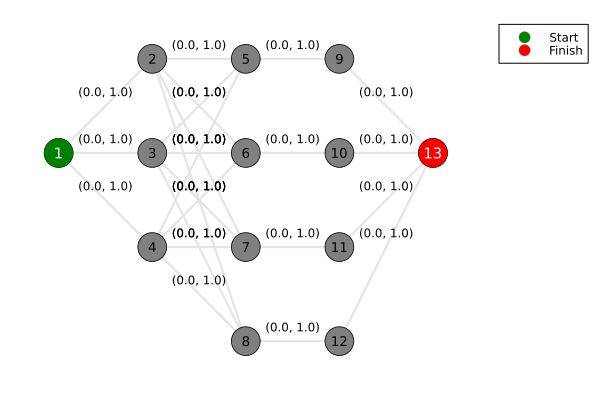

In [16]:
let

    # initialize -
    base_graphmodel = directedgraphmodel;
    source_node = 1; # this is where we start
    target_node = 13; # this is where we want to go

    # draw
    q = plot();
    for (k,v) ∈ base_graphmodel.edgesinverse
       
        # now, get the source,target node index for this edge
        s = v[1];
        t = v[2];
        # draw baseline edge
        plot!([node_coordinates[s,1], node_coordinates[t,1]],[node_coordinates[s,2], node_coordinates[t,2]], arrow=true, color=:gray90, lw=2, label="")
        
        # add weight annotation to edges
        mx = (node_coordinates[s,1] + node_coordinates[t,1]) / 2
        my = (node_coordinates[s,2] + node_coordinates[t,2]) / 2
        c = round.(base_graphmodel.capacity[(s,t)], digits=2) # changed to capacity from weights
        annotate!(mx, my + 0.15, text(string(c), 8, :black))
    end
    scatter!(node_coordinates[:,1], node_coordinates[:,2], axis=nothing, border=:none, label="", c=:gray, ms=16)
    
   
    scatter!([node_coordinates[source_node,1]], [node_coordinates[source_node,2]], 
             c=:green, ms=16, markerstroke=2, markerstrokecolor=:darkgreen, 
             label="Start")

    scatter!([node_coordinates[target_node,1]], [node_coordinates[target_node,2]], 
             c=:red, ms=16, markerstroke=2, markerstrokecolor=:darkred, 
             label="Finish")

    # number the nodes -
    n_nodes = size(node_coordinates, 1)
    for i in 1:n_nodes
        x = node_coordinates[i,1]
        y = node_coordinates[i,2]
        if i == source_node || i == target_node
            # white text for the red source node
            annotate!(x, y, text(string(i), 10, :white))
        else
            # black text for other nodes
            annotate!(x, y, text(string(i), 9, :black))
        end
    end

    # set the global plot attributes
    plot!(axis=nothing, border=:none, legend=:outertopright, legendfontsize=8, 
          background_color=:white, xlim=(9.5, 14.5), ylim=(7.5, 11.5))

    current() # show the current plot
end

___

## Task 2: Formulate the minimum cost maximum flow problem as a linear programming problem
In this task, we translate the data stored in our graph model into the components of our linear programming (LP) problem.  

We have a directed (bipartite) graph with nodes representing sources, sinks, and intermediate nodes representing a matching process. The edges represent the flow of goods or resources between these nodes. Each edge has a capacity (the maximum amount of flow that can pass through it) and a cost per unit of flow.

> __Formulation__: Let the directed graph be represented as $G = (\mathcal{V}, \mathcal{E})$, where $\mathcal{V}$ is the set of vertices (nodes) and $\mathcal{E}$ is the set of edges. Each edge $j \in \mathcal{E}$ has a capacity $c_j$ and a cost (weight) $w_j$ per unit of flow. Let $f_j$ be the flow on edge $j$, and let $s$ be the source node and $t$ be the sink node. The goal is to send a specified amount of flow from the source to the sink while minimizing the total cost of the flow.

We use an incidence matrix formulation where $\mathbf{A} \in \mathbb{R}^{|\mathcal{V}| \times |\mathcal{E}|}$ represents the graph structure. For node $i$ and edge $j$:
- $A_{ij} = 1$ if edge $j$ is incoming to node $i$
- $A_{ij} = -1$ if edge $j$ is outgoing from node $i$  
- $A_{ij} = 0$ otherwise

Putting all this together, we can then formulate the __primal__ minimum cost maximum flow problem as the _primal_ linear program:
$$
\begin{align*}
\text{minimize} &\, \sum_{j \in \mathcal{E}} w_j f_j \\
\text{subject to} \quad \mathbf{A}\mathbf{f} &= \mathbf{b}\\
~0 \leq f_j &\leq c_j \quad\forall j \in \mathcal{E}
\end{align*}
$$
where $\mathbf{f} \in \mathbb{R}^{|\mathcal{E}|}$ is the vector of flows on each edge, and $\mathbf{b} \in \mathbb{R}^{|\mathcal{V}|}$ is the right-hand side vector with:
$$
b_i = \begin{cases}
-F & \text{if } i = s \text{ (source generates flow)} \\
F & \text{if } i = t \text{ (sink consumes flow)} \\
0 & \text{otherwise (flow conservation)}
\end{cases}
$$
where $F$ is the total flow from the source to the sink. The optimal solution to this problem (if it exists) will give the flow on each edge that minimizes the total cost while satisfying the flow conservation constraints and capacity constraints.

Let's start with the bounds.

In [19]:
primal_bounds = let

    # initialize
    capacity = directedgraphmodel.capacity; # get the capacity
    number_of_edges = length(directedgraphmodel.edges); # how many edges do we have
    bounds = Array{Float64,2}(undef, number_of_edges, 2); # each row is an edge, col 1 is lb, col 2 is ub

    # TODO: loop over the edges and set the bounds
    for (k,v) ∈ directedgraphmodel.edgesinverse

        # get the edge index
        edge_index = k;
        lb = capacity[v][1];
        ub = capacity[v][2];

        # get nodes associated with this edge -
        s = v[1];
        t = v[2];

        # set the bounds
        bounds[edge_index, 1] = lb; # lower bound
        bounds[edge_index, 2] = ub; # upper bound
    end

    bounds # return
end;

Next, let's formulate the objective function coefficient vector. The objective function coefficients correspond to the costs associated with each edge in the graph. In our case, we want to minimize the total cost of the flow through the network.

We'll store the objective function coefficients in the `w::Vector{Float64}` vector.

In [21]:
w = let

    # initialize
    number_of_edges = length(directedgraphmodel.edges); # how many edges do we have
    weight_array = Array{Float64,1}(undef, number_of_edges); # each row is an edge
    weights = directedgraphmodel.edges;

    # main loop
    for (k,v) ∈ directedgraphmodel.edgesinverse

        # get the edge index
        edge_index = k;
        wv = weights[v]; # weight value

        s = v[1]; # source node
        t = v[2]; # target node

        
        # TODO: Uncomment the following lines to see what happens when we modify the costs
        if (s == 3)
            # Modify the weight for edge 3 -> 6
            wv = 2*wv; # example modification
        end

        # set the weight
        weight_array[edge_index] = wv; # weight
    end

    
    weight_array # return
end;

Now, let's formulate the right-hand side vector, which corresponds to the flow conservation constraints at each node in the graph. 

> __What's in the $\mathbf{b}$ vector?__ The right-hand side vector $\mathbf{b}\in\mathbb{R}^{|\mathcal{V}|}$ will have a value of `-F::Float64` at the source node, `F::Float64` at the sink node, and `0` at all other nodes. Why is that? The source node generates flow (negative value), the sink node consumes flow (positive value), and intermediate nodes conserve flow (zero net flow).

Let's save the right-hand side vector in the `b::Vector{Float64}` vector.

In [23]:
b = let

    # initialize
    number_of_nodes = length(directedgraphmodel.nodes); # how many nodes do we have
    b = zeros(number_of_nodes); # each row is a node
    s = directedgraphmodel.source; # source node index
    t = directedgraphmodel.sink; # sink node index

    # TODO: change the flow value
    F = 3.0; # flow value (to be sent from source to sink)

    # set the right-hand side values
    b[s] = -F; # source node
    b[t] = F; # sink node

    b; # return
end;

Finally, let's formulate the constraint matrix $\mathbf{A}\in\mathbb{R}^{|\mathcal{V}|\times|\mathcal{E}|}$, which represents the flow conservation constraints at each node in the graph. 
> __What is in the constraint matrix $\mathbf{A}$?__ The constraint matrix will have a row for each node and a column for each edge. Using the incidence matrix convention: The entries in the matrix will be `1` if the edge is **incoming** to a node, `-1` if the edge is **outgoing** from a node, and `0` otherwise.

We'll store the constraint matrix in the `A::Array{Float64, 2}` variable.

In [25]:
A = let

    # initialize
    number_of_nodes = length(directedgraphmodel.nodes); # how many nodes do we have
    number_of_edges = length(directedgraphmodel.edges); # how many edges do we have
    A = zeros(number_of_nodes, number_of_edges); # each row is a node, each col is an edge

    # main loop: fill in the constraint matrix
    for (k,v) ∈ directedgraphmodel.edgesinverse

        # get the edge index
        edge_index = k;

        # get the source and target nodes for this edge
        s = v[1];
        t = v[2];

        # set the entries in the constraint matrix
        A[s, edge_index] = -1.0; # outgoing edge from source node
        A[t, edge_index] = 1.0; # incoming edge to target node
    end

    A # return

end;

Now, let's solve the primal minimum cost maximum flow problem using the GLPK solver through JuMP.

First, we create an instance of [the `MyLinearProgrammingProblemModel` model](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyLinearProgrammingProblemModel) using [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/#VLDataScienceMachineLearningPackage.build) and store this model in the `primal_problem` variable. 
This model holds the data associated with the problem, e.g., the unit costs, the right-hand side vector, the constraint matrix (i.e., the flow conservation constraints), and the problem bounds.

In [27]:
primal_problem = build(MyLinearProgrammingProblemModel, (

    c = -w, # coefficients in the objective function (sum of the costs of operating an edge) # TODO: What is the "sense" of the problem by default?
    A = A, # flow conservation constraints
    b = b, # the net flow at each node

    # how much flow can we send on each edge?
    lb = primal_bounds[:,1], # lower bound on flow on each edge
    ub = primal_bounds[:,2] # upper bound on flow on each edge
));

Next, we pass the `primal_problem` variable to [the `solve(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/solvers/#VLDataScienceMachineLearningPackage.solve), which constructs the linear program using the [JuMP domain-specific language](https://jump.dev/). 

The implementation of [the `solve(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/solvers/#VLDataScienceMachineLearningPackage.solve) takes the data from the `primal_problem` instance, builds the various problem structures, and returns the solution in the `primal_solution` dictionary.

> __Why the try-catch block?__ The [solve(...) method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/solvers/#VLDataScienceMachineLearningPackage.solve) uses the [GLPK solver](https://en.wikipedia.org/wiki/GLPK) to solve the linear program. If the solver fails, the `solve(...)` method will throw an error. To prevent the notebook from crashing, we wrap the call to [the `solve(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/solvers/#VLDataScienceMachineLearningPackage.solve) in a `try-catch` block. If the solver fails, we catch the error and print a message to the user.

Solve the primal problem. The solution will be stored in the `primal_solution::Dict{String, Any}` dictionary.

In [29]:
primal_solution_dictionary = let

    # initialize -
    primal_solution = nothing;
    try
        primal_solution = solve(primal_problem, constraints = :eq) # call the solver
    catch error
        println(error)
    end
    
    primal_solution; # return
end;

What's the minimum cost of the flow through the network? 

In [31]:
primal_solution_dictionary["objective_value"] |> abs # What's the minimum cost of the flow through the network?

7.0

___

## Task 3: Setup and solve the dual linear programming problem
In this task, we will set up and solve the __dual__ linear programming (LP) problem using the components we computed in Task 2. However, there are a couple of important considerations here. 

First, the bounds on the dual variables are different from the primal problem. In particular, the dual variables (which correspond to the nodes in the graph) are __unbounded__. Second, the constraint matrix for the dual problem is the transpose of the primal constraint matrix. Third, the objective function coefficients for the dual problem are the right-hand side vector from the primal problem. Finally, if we are minimizing the primal problem, then we are maximizing the dual problem.

The __dual problem__ has the form:
$$
\begin{aligned}
\text{maximize}\quad & \sum_{j=1}^{m} b_{j} y_{j}\\
\text{subject to}\quad & \sum_{j=1}^{m} A_{j,i} y_{j} \le w_{i}
\quad&&i=1,2,\dots,n,\\
&-\infty\leq{y_{j}}\leq\infty\quad(\text{free})
\quad&&j=1,2,\dots,m.
\end{aligned}
$$


Most of these issues are easy to address. However, we'll need to replace the bounds on the dual variables. In particular, we'll set the lower bound to `-Inf` and the upper bound to `Inf` for each dual variable. 

> __Why are the dual variables unbounded?__ The dual variables correspond to the nodes in the graph, and since we have equality constraints in the primal problem (flow conservation), the dual variables are free (unbounded). This means that they can take on any value, positive or negative, without any restrictions.

Let's save this in the `dual_bounds::Array{Float64, 2}` variable.

In [34]:
dual_bounds = let

    # initialize
    number_of_nodes = length(directedgraphmodel.nodes); # how many nodes do we have
    dual_bounds = Array{Float64,2}(undef, number_of_nodes, 2); # each row is a node, col 1 is lb, col 2 is ub

    # set the bounds for each dual variable (node)
    for i in 1:number_of_nodes
        dual_bounds[i, 1] = -Inf; # lower bound
        dual_bounds[i, 2] = Inf; # upper bound
    end

    dual_bounds # return
end;


Next, we create an instance of [the `MyLinearProgrammingProblemModel` model](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/types/#VLDataScienceMachineLearningPackage.MyLinearProgrammingProblemModel) using [a `build(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/factory/#VLDataScienceMachineLearningPackage.build) and store this model in the `dual_problem` variable. 
This model holds the data associated with the problem, such as the unit costs, the right-hand side vector, the constraint matrix (i.e., the flow conservation constraints), and the problem bounds.

__Note:__ The LP solution implementation in [the `VLDataScienceMachineLearningPackage.jl` package](https://github.com/varnerlab/VLDataScienceMachineLearningPackage.jl/tree/main) by default __maximizes__ the objective function. This is the correct sense for our dual problem, so we do not need to change the sign of the objective function coefficients.

However, we can explore different constraint formulations. In particular, we can solve the dual problem with equality constraints, i.e., $\mathbf{A}^{\top}\mathbf{y} = \mathbf{w}$, or with inequality constraints, i.e., $\mathbf{A}^{\top}\mathbf{y} \geq \mathbf{w}$.

In [36]:
rand(100,100) |> transpose

100×100 transpose(::Matrix{Float64}) with eltype Float64:
 0.579862   0.411294   0.972136   …  0.971588   0.29429    0.93114
 0.191903   0.0143609  0.406722      0.996993   0.0916464  0.333527
 0.285126   0.562245   0.511923      0.352111   0.102077   0.0162912
 0.15125    0.697986   0.495965      0.0662396  0.69992    0.145137
 0.691972   0.620749   0.213738      0.474806   0.540316   0.460747
 0.700862   0.782667   0.277679   …  0.686633   0.68729    0.861337
 0.531231   0.350845   0.54379       0.136743   0.593534   0.000958693
 0.842389   0.369588   0.346607      0.316096   0.557644   0.509859
 0.110292   0.980295   0.565295      0.246852   0.845127   0.211999
 0.655269   0.354887   0.624235      0.481554   0.401528   0.58985
 0.473374   0.176997   0.676856   …  0.607296   0.160539   0.442075
 0.0853328  0.842512   0.669759      0.986081   0.560997   0.998356
 0.333645   0.762669   0.751468      0.591309   0.99606    0.572533
 ⋮                                ⋱                     

In [37]:
dual_problem = build(MyLinearProgrammingProblemModel, (

    c = b, # coefficients in the dual objective function (flow requirements at each node)
    A = transpose(A) |> Matrix, # dual constraint matrix (transpose of primal incidence matrix)
    b = w, # right-hand side for dual constraints (edge costs from primal)

    # bounds on dual variables (node prices/shadow prices)
    lb = dual_bounds[:,1], # lower bound on dual variables (unbounded)
    ub = dual_bounds[:,2] # upper bound on dual variables (unbounded)
));

Next, we pass the `dual_problem` variable to [the `solve(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/solvers/#VLDataScienceMachineLearningPackage.solve), which constructs the linear program using the [JuMP domain-specific language](https://jump.dev/). 

The implementation of [the `solve(...)` method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/solvers/#VLDataScienceMachineLearningPackage.solve) takes the data from the `dual_problem` instance, builds the various problem structures, and returns the solution in the `dual_solution` dictionary.

> __Why the try-catch block?__ The [solve(...) method](https://varnerlab.github.io/VLDataScienceMachineLearningPackage.jl/dev/solvers/#VLDataScienceMachineLearningPackage.solve) uses the [GLPK solver](https://en.wikipedia.org/wiki/GLPK) to solve the linear program. If the solver encounters an error, the `solve(...)` method will throw an exception. To prevent the notebook from crashing, we wrap the call in a `try-catch` block. If the solver fails, we catch the error and print a message to the user.

Solve the dual problem. The solution will be stored in the `dual_solution::Dict{String, Any}` dictionary.

In [39]:
dual_solution_dictionary = let

    # initialize
    dual_solution = nothing;
    try
        dual_solution = solve(dual_problem, constraints = :leq) # call the solver
    catch error
        println(error)
    end

    dual_solution; # return
end;

What's in the solution dictionary?

In [41]:
dual_solution_dictionary

Dict{String, Any} with 3 entries:
  "argmax"          => [-1.0, -1.0, -1.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1…
  "status"          => OPTIMAL
  "objective_value" => 6.0

In [42]:
let

    # initialize
    df = DataFrame();
    y = dual_solution_dictionary["argmax"]; # get the dual variables
    number_of_nodes = length(directedgraphmodel.nodes); # how many nodes do we have

    for i ∈ 1:number_of_nodes

        # get the dual variable for this node
        yi = y[i];

        # add to the dataframe
        push!(df, (Node=i, DualVariable=yi))
    end

    pretty_table(df)
end

┌───────┬──────────────┐
│  Node │ DualVariable │
│ Int64 │      Float64 │
├───────┼──────────────┤
│     1 │         -1.0 │
│     2 │         -1.0 │
│     3 │         -1.0 │
│     4 │         -1.0 │
│     5 │          0.0 │
│     6 │          0.0 │
│     7 │          0.0 │
│     8 │          0.0 │
│     9 │          1.0 │
│    10 │          1.0 │
│    11 │          1.0 │
│    12 │          1.0 │
│    13 │          1.0 │
└───────┴──────────────┘


So, do we have a duality gap? For __minimization__ problems, the duality gap is $\mathbf{c}^{\top} \mathbf{x} - \mathbf{b}^{\top} \mathbf{y} \geq 0$ (this is a little tricky, more than it first may appear to be).

In [44]:
let

    # initialize -
    x = primal_solution_dictionary["argmax"]; # get the primal variables
    y = dual_solution_dictionary["argmax"]; # get the dual variables
    
    # compute the gap -
    gap = transpose(w) * x - transpose(b) * y # duality gap for minimization problem

    # println -
    println("Duality gap (should be >= 0): ", gap)
end

Duality gap (should be >= 0): 1.0


## So how should we interpret the dual solution for a flow problem?

The dual solution for this type of problem is a little mystical. One tempting (but problematic) way to think about the dual variables is they represent the sensitivity of the objective function to changes in the right-hand side constraints:
$$
y_{i} \simeq \frac{\partial z}{\partial b_{i}}
$$
where $z$ is the optimal objective function value, and $b_{i}$ is the right-hand side constraint for node $i$ in the primal problem. However, the classical sensitivity interpretation is a bit tricky for min-cost flow problems because of a few gotchas.

1. **Gauge freedom (signs are meaningless).** A feasible $\mathbf{b}$ vector satisfies $\sum_i b_i=0$. So the marginal you care about is a transfer: moving $+1$ unit from node $j$ to node $i$ changes the optimal cost by $y_i - y_j$ (not by $y_i$ in isolation). Furthermore, add any constant $\alpha$ to every $y_i$ and nothing changes: constraints, reduced costs, or $\mathbf{b}^\top \mathbf{y}$ (since $\sum_i b_i=0$). Thus, only differences like $y_v-y_u$ matter (not absolute values).

2. **Sensitivity in one glance (shadow prices).** So if we return to the sensitivity interpretation, we can see that $y_i$ are **marginal values**: moving $+1$ unit of supply/demand from node $j$ to $i$ changes optimal cost by $y_i-y_j$.

3. **Reduced costs.** The dual constraints say $y_v - y_u \le w_{uv}$ on each arc $(u\to v)$. Rearranging gives the **reduced cost** of arc $(u\to v)$:
   $$\bar r_{uv} = w_{uv} - (y_v - y_u) \ge 0.$$
   This is the extra cost of pushing flow on that arc, given the node prices. If $\bar r_{uv}=0$, the arc can handle more flow at zero cost (unless it is already saturated). On the other hand, if $\bar r_{uv}>0$, the arc is unattractive.

4. **Optimality certificate (one number to check).** A feasible $\mathbf{y}$ with $\mathbf{A}^\top \mathbf{y} \le w$ gives a lower bound $\mathbf{b}^\top \mathbf{y}$ on the primal cost. When your flow has the same cost, you’re **done**. No hand-waving, the dual $\mathbf{y}$ proves optimality.

__TL;DR__:  Dual prices $\mathbf{y}$ are a **certificate and a compass**: they certify your flow is optimal ($\mathbf{b}^\top \mathbf{y}$ matches the primal cost) and they point to which arcs are worth using (zero reduced cost) and where extra capacity or demand shifts actually matter.

Stop caring about the absolute sign of $y_i$. Care about differences ($y_i-y_j$) and reduced costs ($\mathbf{w} - \mathbf{A}^\top \mathbf{y}$). Then the dual stops being mystical!

___


## Summary
In this activity, we explored how to formulate and solve minimum cost maximum flow problems using **dual linear programming**. We transformed a graph-based optimization problem into its dual mathematical programming formulation and solved it using the GLPK solver through JuMP, gaining insights into shadow prices (the economic value of resources) and their practical interpretations.

> **Key takeaways:**
> * **Dual formulation reveals economic insights.** We converted a minimum cost maximum flow graph problem into its dual linear program, where dual variables represent node prices (shadow prices) rather than edge flows, helping us understand the economic value and cost structure of optimal solutions.
> * **Dual variables are unbounded node prices.** Unlike primal flow variables that have capacity limits, dual variables representing node prices are free (can be any value) because they correspond to flow conservation constraints in the original problem.
> * **Price differences and reduced costs matter most.** The absolute values of dual variables don't mean much on their own; what matters are the differences between node prices ($y_i - y_j$) and reduced costs ($w_{ij} - (y_j - y_i)$) which tell us about marginal costs (the cost of sending one additional unit of flow) and which edges are most attractive to use.

**Where do we go from here?** The dual perspective on minimum cost maximum flow problems gives us tools for sensitivity analysis (understanding how changes affect costs), and proving that our solution is truly optimal. We can extend these ideas to more complex scenarios like multi-commodity flows, network design problems, or auction systems where shadow prices help determine fair pricing.

Understanding both the primal (flow-based) and dual (price-based) perspectives gives you a complete toolkit for analyzing and solving network flow problems in engineering, economics, and operations research!
___